# Importing Libraries

In [2]:
pip install torch


Note: you may need to restart the kernel to use updated packages.


The filename, directory name, or volume label syntax is incorrect.


In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.10.2


# Preparing Training and Test Sets

THE DATASET USED FOR THE TRAINING OF MODEL AND USED FOR TESTING IS TAKEN FROM :
https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database

In [6]:
class_names = ['normal', 'viral', 'covid']
root_dir = r'C:/Users/Atreus/Desktop/abrar/COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [7]:
class ChestXRayDataset(torch.utils.data.Dataset): #subclass of dataset class from pytorch    def __init__(self, image_dirs, transform): #parameters are image_dirs for image directories for preclasses and transform for image augmentations
    def __init__(self, image_dirs, transform):    
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found{len(images)} {class_name} examples')
            return images
            
        self.images = {}
        self.class_names = ['normal' , 'viral' , 'covid']
        
        for c in self.class_names: #iterate over these class names
            self.images[c] = get_images(c) #list having all the images
            
        self.image_dirs = image_dirs  #saving image directories and transform function  
        self.transform = transform
    
    def __len__(self):  #consists of the length of the dataset
        return sum([len(self.images[c]) for c in self.class_names ])
    
    
    
    def __getitem__(self, index):  
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name]) #preventing the class imbalance for covid chest xrays
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB') #"Image" is being converted into RGB from black and white.
        return self.transform(image), self.class_names.index(class_name)
        #Note that pytorch can only work on tensors and not images and hece we wil have to convert these images to tensors

# Image Transformations

In [8]:
train_transform = torchvision.transforms.Compose([  #creating transformation objects
    torchvision.transforms.Resize(size = (224, 224)), #Converting images into sizes which the model expects
    torchvision.transforms.RandomHorizontalFlip(),  #Applying random horizontal flip, used to augment our dta
    torchvision.transforms.ToTensor(), #Converting images into tensors
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], #Normalising the data according to imagenet where the pytorch model was trained and using the mean and standard deviation of those images
                                    std =[0.229, 0.224, 0.225] )
])


In [9]:
test_transform = torchvision.transforms.Compose([  #creating transformation objects
    torchvision.transforms.Resize(size = (224, 224)), #Converting images into sizes which the model expects
    torchvision.transforms.ToTensor(), #Converting images into tensors
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], #Normalising the data according to imagenet where the pytorch model was trained and using the mean and standard deviation of those images
                                    std =[0.229, 0.224, 0.225] )
])

# Prepare DataLoader

In [11]:
train_dirs = {
    'normal': 'C:/Users/Atreus/Desktop/abrar/COVID-19_Radiography_Dataset/split_folder/train/Normal',
    'viral': 'C:/Users/Atreus/Desktop/abrar/COVID-19_Radiography_Dataset/split_folder/train/Viral Pneumonia',
    'covid': 'C:/Users/Atreus/Desktop/abrar/COVID-19_Radiography_Dataset/split_folder/train/COVID'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found8153 normal examples
Found1076 viral examples
Found2892 covid examples


In [12]:
test_dirs = {
    'normal': 'C:/Users/Atreus/Desktop/abrar/COVID-19_Radiography_Dataset/split_folder/val/Normal',
    'viral': 'C:/Users/Atreus/Desktop/abrar/COVID-19_Radiography_Dataset/split_folder/val/Viral Pneumonia',
    'covid': 'C:/Users/Atreus/Desktop/abrar/COVID-19_Radiography_Dataset/split_folder/val/COVID'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found2038 normal examples
Found269 viral examples
Found723 covid examples


In [13]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

print('training batches', len(dl_train))
print('test batches', len(dl_test))

training batches 2021
test batches 505


# Data Visualization

In [14]:

class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize = (8,4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i+1, xticks = [], yticks = [])  #six images in a column along with index starting with 1 and keeping xticks and yticks empty
        image = image.numpy().transpose((1, 2, 0)) #after loading the data, images will actualy be in tenor. so, we need to convert the tensor into numpy multidimensional array and we also need to transpose it in a away where first axis is the last one because in pytorch tensors the former is the first one
        mean = np.array([0.485, 0.456, 0.406]) #since we normalised the values in previous cells, we will reverse that action here
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean #converting image values into their original ones
        image = np.clip(image, 0., 1.) #clipping the values between 0 and 1
        plt.imshow(image)
        
        col = 'green' if preds[i] == labels[i] else 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}') #whenever we use numpy, we convert the tensors into numerical values
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col) #coloring the ylabel according to the predictions
    plt.tight_layout()
    plt.show()
        

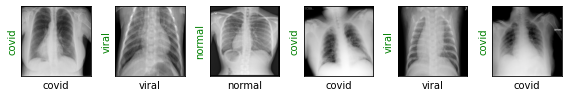

In [15]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

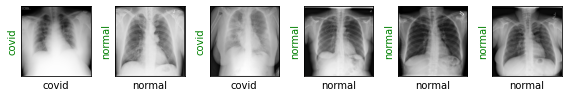

In [16]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [17]:
resnet18 = torchvision.models.resnet18(pretrained = True) #Using resnet18 model from pytorch for training purposes as  it is a relatively smaller convolutional model and also using pretrained weights/labels as well
print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Atreus/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
resnet18.fc = torch.nn.Linear(in_features = 512, out_features = 3) #sInce we are dealing with three classes only, we will change the number of output features from 1000 to 3
loss_fn = torch.nn.CrossEntropyLoss() #since we have a classification problem, we will need an appropriae loss function, which we are choosing to be cross entropy loss function
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5) #we will also need an optimiser function. we are using adam function available in pytorch library
#optimiser is based on stochastic gradient descent. we want to optimise all the parameters of the model
#we are setting the learning rate as 3e-5 which turned out to be the best rate uusing hit and trial


In [19]:
def show_preds(): #we will check the predictions now
    resnet18.eval() #changing the model to evaluation mode
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

In [ ]:
#we currently ran the model on pretrained weights. will now train the model for better accuracy

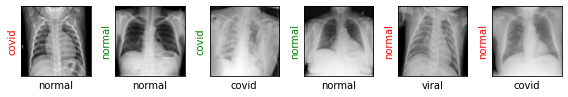

In [20]:
show_preds()

# Training the Model

In [21]:
def train(epochs): #PASS NUMBER OF EPOCHS WE WANT TO TRAIN OUR MODEL FOR
    print('Starting training..') #RUN THESE EPOCH ITERATIONS, AND WITHIN EACH EPOCH THERE WILL BE MORE NUMMBER OF ITERATION STEPS
    for e in range(0, epochs): 
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train): #TRAINING STEP
            optimizer.zero_grad()   #REFRESHING THE OPTIIZER
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()  #GRADIENT DESCENT AKA BACK PROPAGATION
            optimizer.step() #UPDATING HYPERPARAMTERS
            train_loss += loss.item() 
            if train_step % 20 == 0: #every 20th step we are evaluating our model
                print('Evaluating at step', train_step)

                accuracy = 0 

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)  #INDICES FOR PREDICTIONS
                    accuracy += sum((preds == labels).numpy()) #CONVERTING TENSORS TO NUMBERS USING NUMPY

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train() #SETTING THE MODEL TO TRAINING PHASE AGAIN

                if accuracy >= 0.95: #ONCE THE ACCURACY IS GREATER THAN 95%, TRAINING WILL END
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}') #CALCULATING TRAINING LOSS POST TRAINING
    print('Training complete..')               

    

Starting training..
Starting epoch 1/5
Evaluating at step 0
Validation Loss: 1.0756, Accuracy: 0.4076


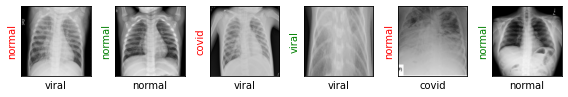

Evaluating at step 20
Validation Loss: 0.8054, Accuracy: 0.5815


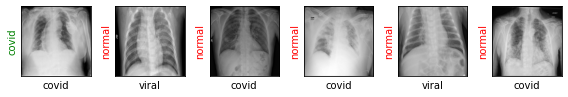

Evaluating at step 40
Validation Loss: 0.5488, Accuracy: 0.8046


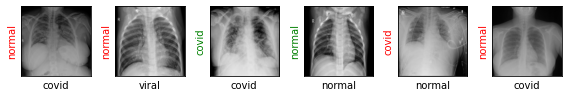

Evaluating at step 60
Validation Loss: 0.3575, Accuracy: 0.8710


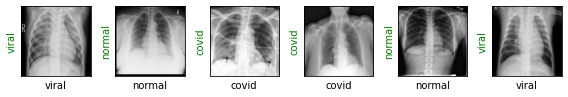

Evaluating at step 80
Validation Loss: 0.3023, Accuracy: 0.8858


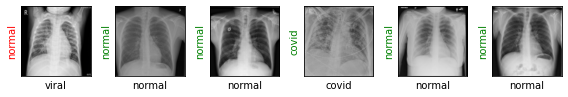

Evaluating at step 100
Validation Loss: 0.2899, Accuracy: 0.8934


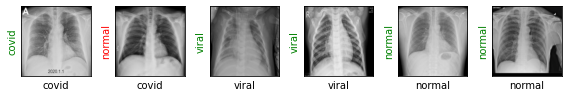

Evaluating at step 120
Validation Loss: 0.2635, Accuracy: 0.9119


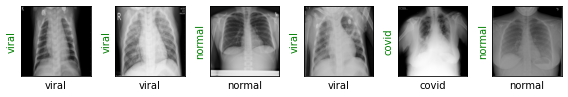

Evaluating at step 140
Validation Loss: 0.2670, Accuracy: 0.8950


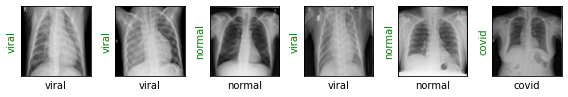

Evaluating at step 160
Validation Loss: 0.2320, Accuracy: 0.9162


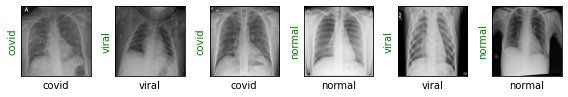

Evaluating at step 180
Validation Loss: 0.1992, Accuracy: 0.9261


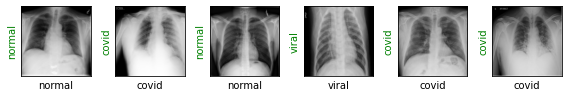

Evaluating at step 200
Validation Loss: 0.1750, Accuracy: 0.9403


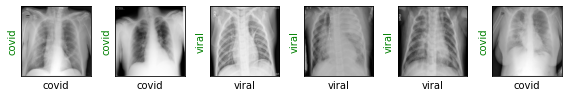

Evaluating at step 220
Validation Loss: 0.1716, Accuracy: 0.9505


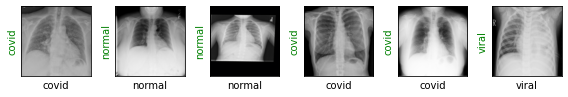

Performance condition satisfied, stopping..


In [22]:

train(epochs = 5)

# Final Results

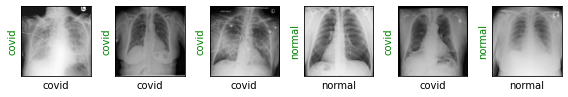

In [23]:
show_preds()